In [1]:
%matplotlib notebook

from rlsm.datasets import load_consulting
from rlsm import ReciprocityLSM

In [2]:
Y = load_consulting()

In [3]:
model = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|████████████████████████████████████████████████████████████████| 7500/7500 [01:05<00:00, 115.03it/s, 63 steps of size 5.15e-02. acc. prob=0.83]


In [4]:
model.print_summary()

AUC: 0.970, WAIC: 2396.036

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
  recip_coef      0.49      0.36      0.49     -0.21      1.19   1794.43      1.00
   dist_coef      0.43      0.07      0.44      0.28      0.58   1938.74      1.00
       s_var      2.21      0.48      2.16      1.34      3.16    949.73      1.00
       r_var      0.71      0.18      0.69      0.39      1.07   1484.98      1.00
     sr_corr     -0.15      0.17     -0.15     -0.47      0.17    948.48      1.00

Number of divergences: 61


<IPython.core.display.Javascript object>


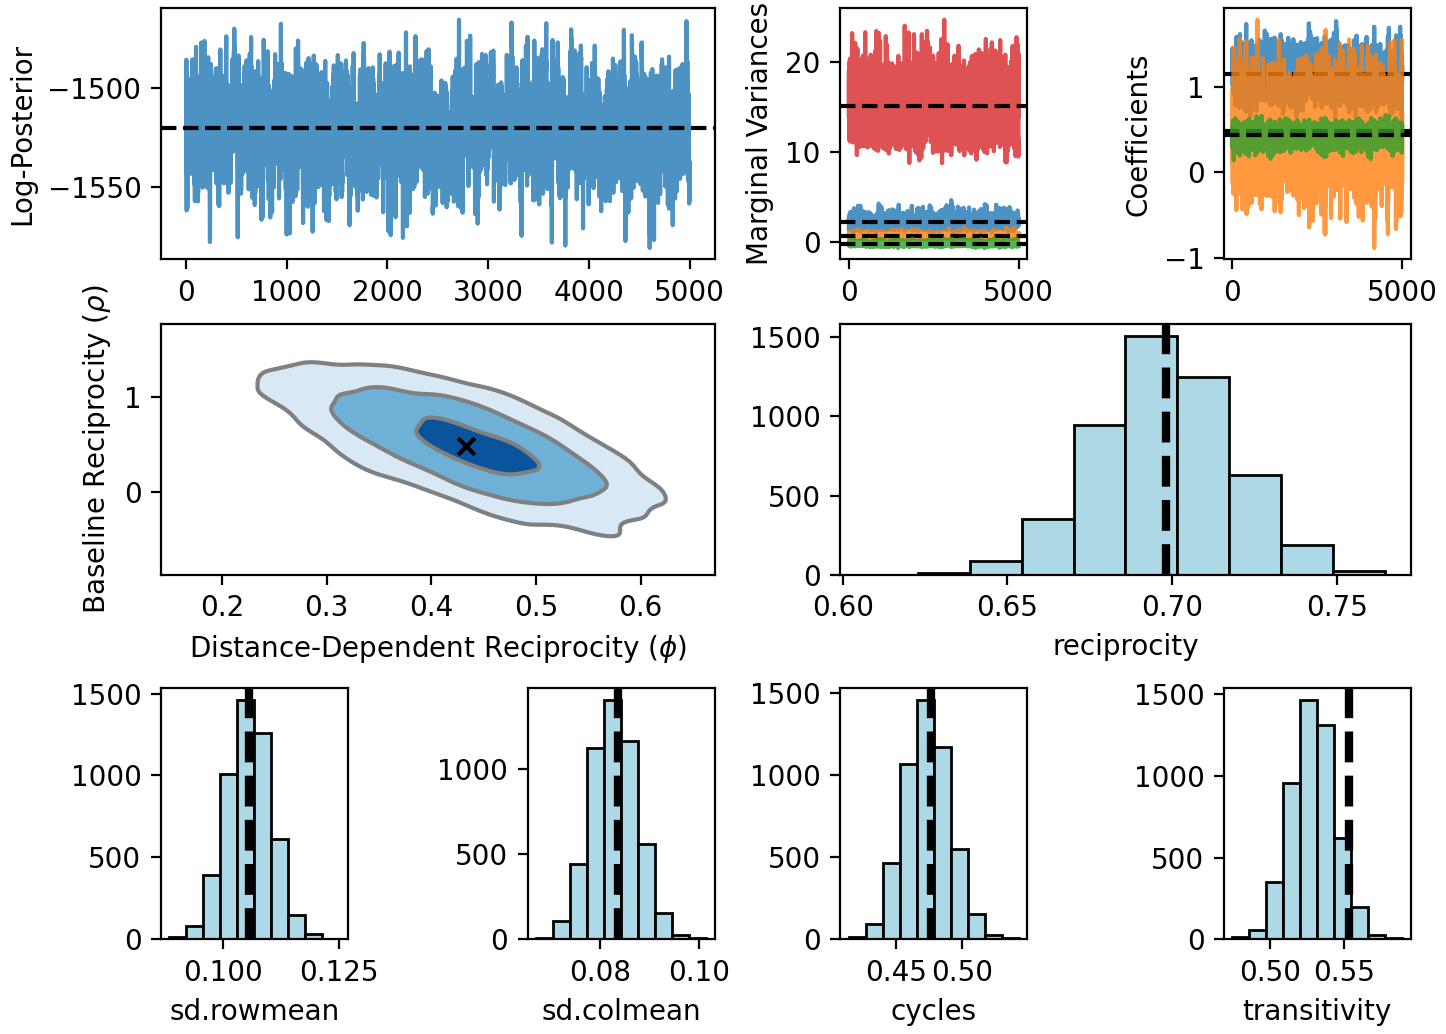

In [5]:
model.plot();

<IPython.core.display.Javascript object>


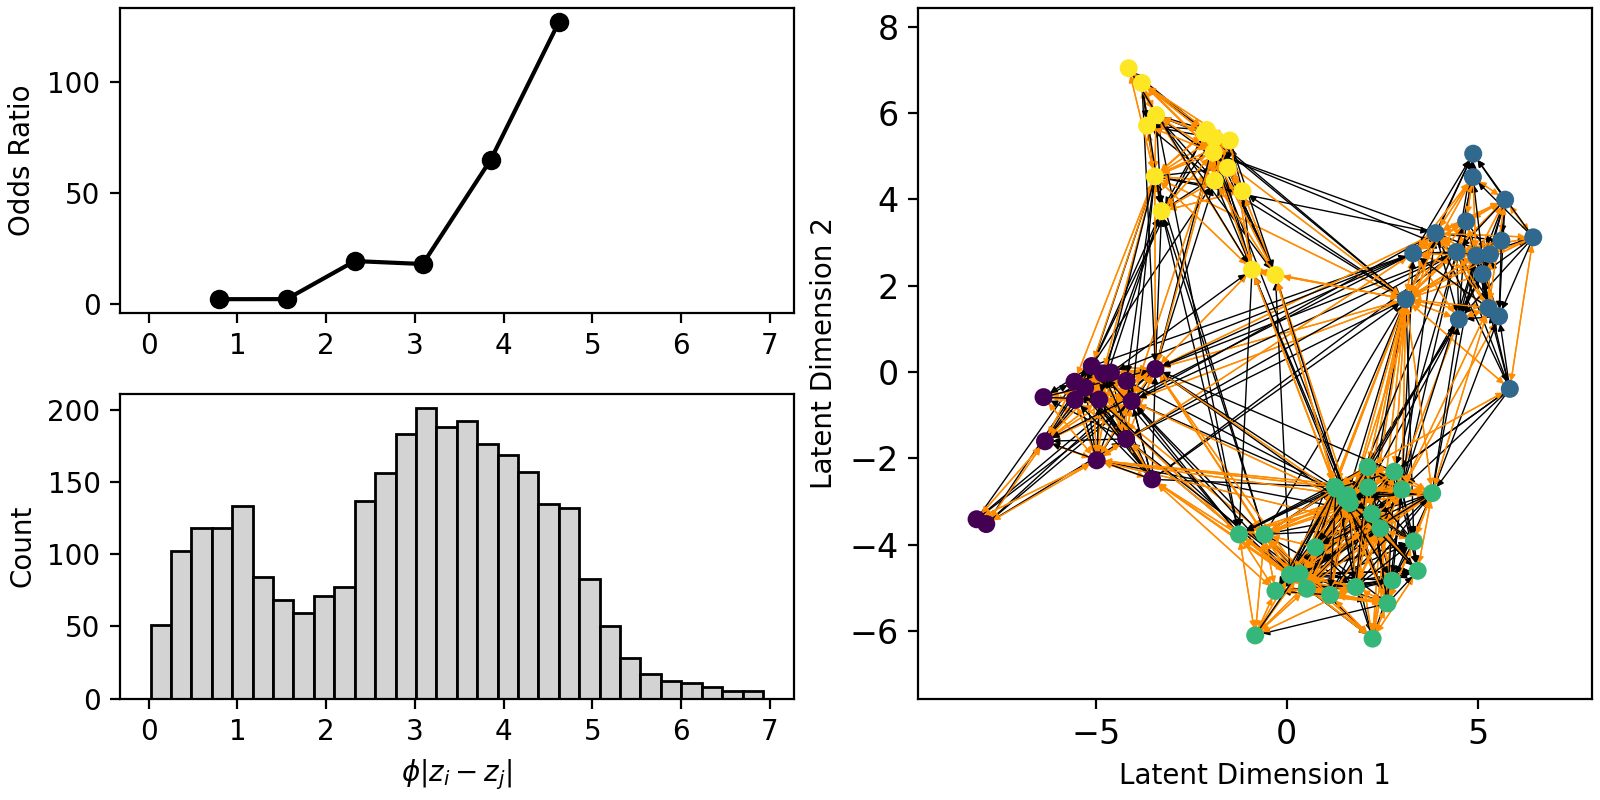

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_50438/4219014761.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [4]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
qs = np.linspace(d.min(), d.max(), 10)
#qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i], d <= qs[i+1]))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if tots[1] * tots[2] > 0:
        res.append(gamma)
        dist.append(qs[i+1])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

<IPython.core.display.Javascript object>


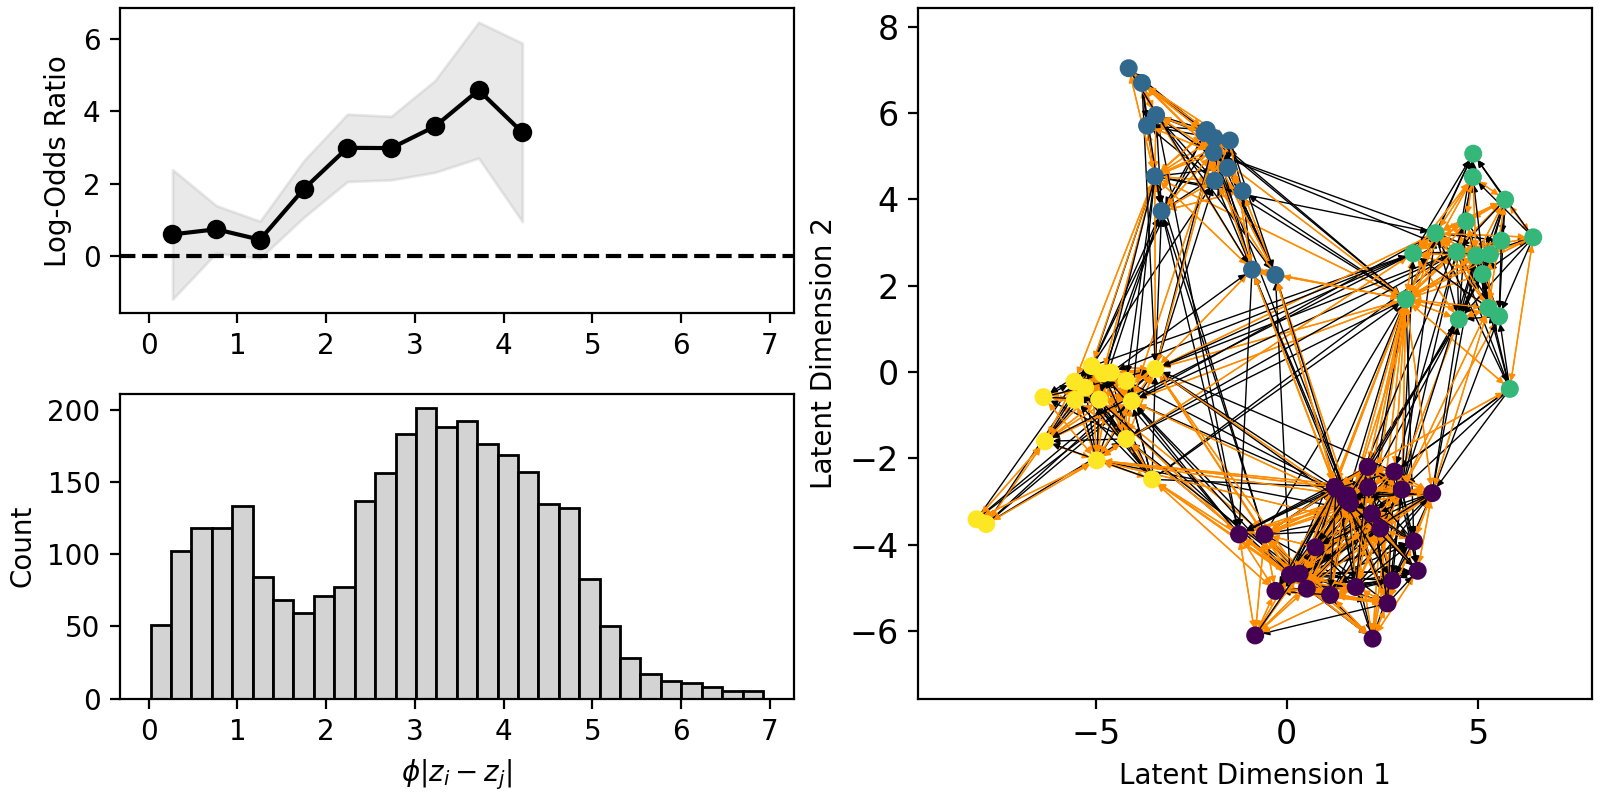

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_50438/1173020858.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [34]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.linspace(d.min(), d.max(), 15)
#qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
diff = np.diff(qs)[0] * 0.5
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i] - diff, d <= qs[i] + diff))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if np.prod(tots) > 0:#tots[1] * tots[2] > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(qs[i] + diff)

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Log-Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')
ax['A'].axhline(0., color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

<IPython.core.display.Javascript object>


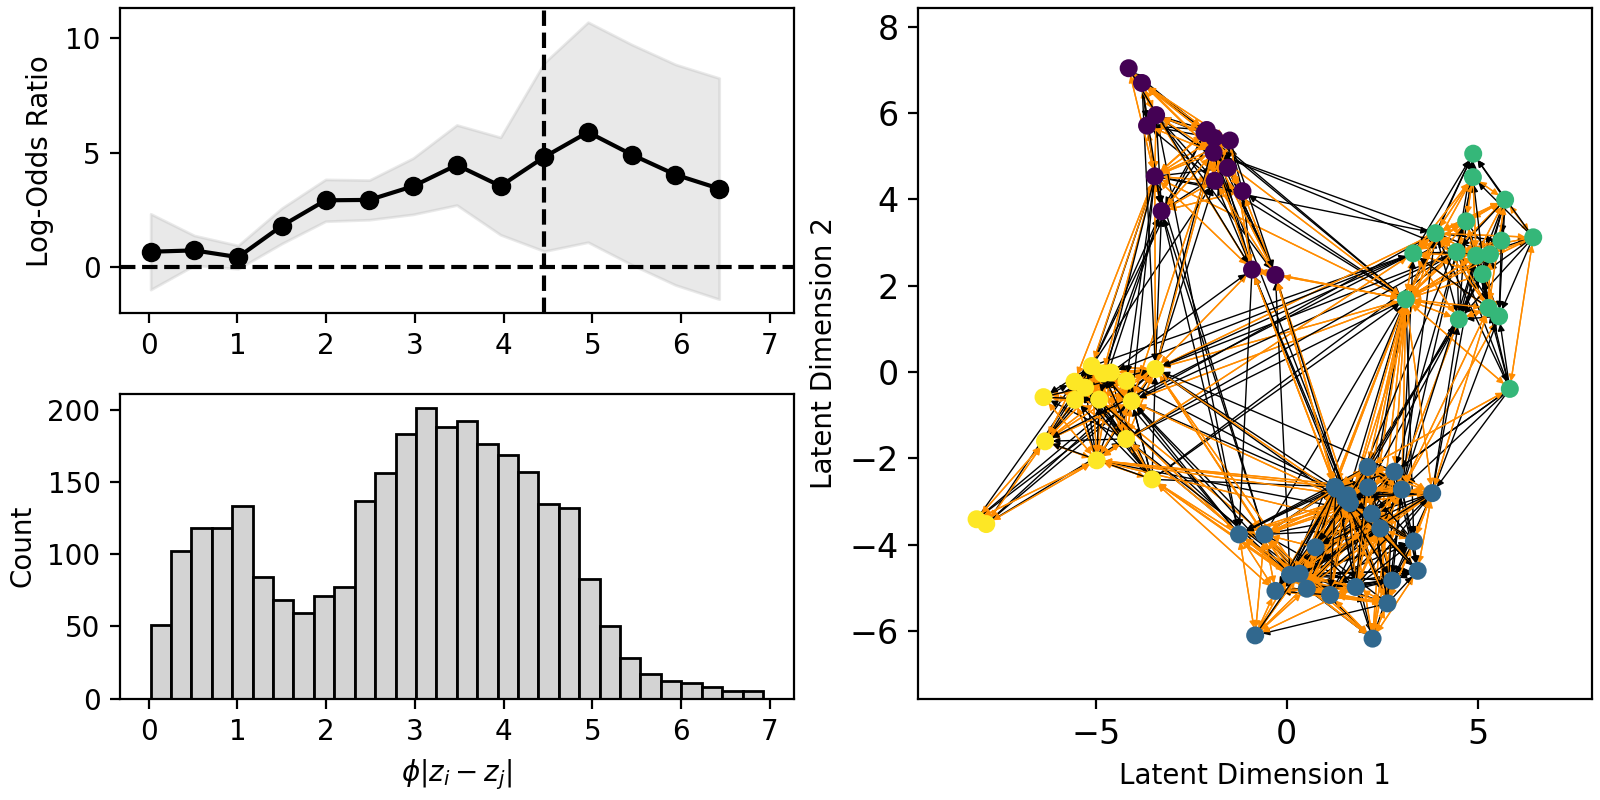

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_50438/3562899181.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [49]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.linspace(d.min(), d.max(), 15)
#qs = np.quantile(d, q=np.linspace(0, 1, 20))
dist = []
prods = []
diff = np.diff(qs)[0] * 0.5
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i] - diff, d <= qs[i] + diff))[0]])
    tots = a.sum(axis=0) 
    prods.append(np.prod(tots))
    tots += 0.5
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if np.prod(tots) > 0:#tots[1] * tots[2] > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(qs[i])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Log-Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')
ax['A'].axhline(0., color='k', linestyle='--')
ids = np.where(np.asarray(prods) == 0)[0][0]
ax['A'].axvline(dist[ids], color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

In [42]:
np.where(np.asarray(prods) == 0)

(array([ 9, 10, 11, 12, 13]),)

In [46]:
ids


array([ 9, 10, 11, 12, 13])